## Instruction
In this notebook, we will complete backtest which is the last step.

In [1]:
import sys
sys.path.append('../')
import numpy as np
import pandas as pd
from tqdm import tqdm

import scipy
from scipy.optimize import fmin_l_bfgs_b
from sklearn.decomposition import PCA

from statistics import median
from scipy.stats import gaussian_kde, zscore
from statsmodels.formula.api import ols

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 4]

import warnings
warnings.filterwarnings('ignore')

import feather

### Load Factors
We have factors store in csv file which process and combine from privious steps. Pick up backtest time from 2022.4 - 2022.3

In [2]:
universe_raw = feather.read_dataframe('bitcoin_data/factor_data/facotor4h_bitcon_combine.feather')
#universe_raw['date'] = pd.to_datetime(universe_raw['trade_date'], format='%Y-%m-%d %H:%M:%S')
universe = universe_raw.set_index(['date']).sort_values(by=['date', 'ts_code'])
print(universe.shape)

(90570, 8)


In [3]:
universe.columns

Index(['ts_code', 'close', 'log-ret', 'trade_date', 'alpha_019', 'alpha_t4',
       'alpha_075', 'alpha_combine'],
      dtype='object')

In [4]:
# def sum_ret(series):
#     return series.sum()
# universe = universe.groupby('ts_code').resample('2H').agg({'close':'last', 'log-ret':sum_ret, 
#                                     'alpha_019':'last', 'alpha_t1':'last', 'alpha_AI':'last', })
# universe = universe.reset_index().set_index(['date']).sort_values(by=['date', 'ts_code'])
# universe['trade_date'] = universe.index
# universe.index.unique()[-1]

In [5]:
# only use from 2023.2.27 to 2023.5.29, here use 48 hours to generate risk model from history
time_str = '2023-03-01 00:00:00'
time_timestamp = pd.to_datetime(time_str)
#start_time_timestamp = universe.index.unique()[0] - pd.DateOffset(hours=48)
start_time_timestamp = time_timestamp - pd.DateOffset(hours=80)
universe = universe.loc[universe.index>=start_time_timestamp].sort_values(by=['date', 'ts_code'])

In [6]:
start_time_timestamp

Timestamp('2023-02-25 16:00:00')

In [7]:
print(universe.index.unique()[0])
print(len(universe.ts_code.unique()))
set(universe.ts_code.unique()) - set(universe.loc[universe.index==universe.index.unique()[0]].ts_code.unique())

2023-02-25 16:00:00
35


set()

In [8]:
universe = universe.loc[universe.ts_code!='TUSDUSDT'].sort_values(by=['date', 'ts_code'])

<AxesSubplot:>

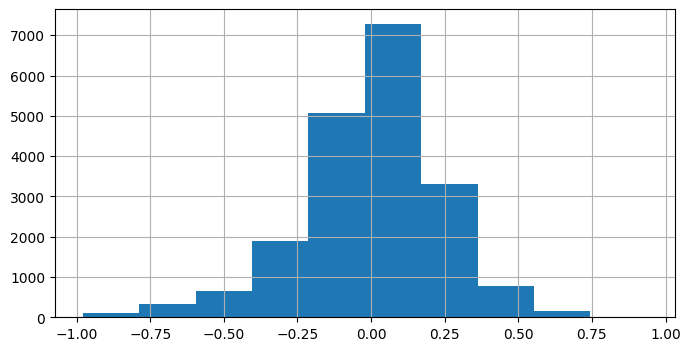

In [9]:
#universe['alpha_AI2'] = (universe['alpha_AI'] + universe['alpha_078'])/2
#print(universe['alpha_AI2'].median())
universe['alpha_combine'].hist()

### Factor Exposures and Factor Returns
The facort values in cross section should view as a type of exposure. We can calculate factor returns bettwen exposures of each ticker and daily return. We also did this in backtestig animate notebook.

In [10]:
import random
universe = universe.sort_values(by=['date', 'ts_code'])
all_factors = universe.copy(deep=True)
def return_handle(df):
    df['returns_2'] = df['close'].pct_change().shift(-1)
#     noise_list = []
#     for i in range(df.shape[0]):
#         noise = abs(random.gauss(0, 0.1))
#         if noise > 0.1:
#             noise=0.05
#         noise_list.append(noise)
#     df['returns_2'] = df['returns_2'] * (1-np.array(noise_list)) \
#                     + np.array(noise_list)*(df['close'].pct_change().shift(-1).fillna(0.))
    return df

all_factors = all_factors.groupby('ts_code').apply(return_handle)
all_factors = all_factors.replace([np.inf, -np.inf], np.nan).fillna(0.).sort_values(by=['date', 'ts_code'])
print(universe.shape, all_factors.shape)

(19600, 8) (19600, 9)


In [11]:
def keep_top_bottom(data, feature, bottom=0.3, top=0.7):
    tv = data[feature].quantile(top)
    bv = data[feature].quantile(bottom)
    data[feature] = np.where(data[feature]>=tv, data[feature], 
                            np.where(data[feature]<=bv, data[feature], 0))
    return data

def wins(x,a,b):
    return np.where(x <= a,a, np.where(x >= b, b, x))

def get_formula(factors, Y):
    L = ["0"]
    L.extend(factors)
    return Y + " ~ " + " + ".join(L)

def factors_from_names(n, name):
    return list(filter(lambda x: name in x, n))

def estimate_factor_returns(df, name='alpha_'): 
    ## winsorize returns for fitting
    estu = df.copy(deep=True)
    estu['returns_2'] = wins(estu['returns_2'], -0.2, 0.2)
    all_factors_name = factors_from_names(list(df), name)
    results = pd.Series()
    for factor_name in all_factors_name:
        estu = keep_top_bottom(estu, factor_name)
        form = get_formula([factor_name], "returns_2")
        model = ols(form, data=estu)
        result = model.fit()
        results = results.append(result.params)
    return results

#estimate_factor_returns(all_factors.loc[all_factors['trade_date']=='2023-05-01 00:00:00'])

In [12]:
universe.columns

Index(['ts_code', 'close', 'log-ret', 'trade_date', 'alpha_019', 'alpha_t4',
       'alpha_075', 'alpha_combine'],
      dtype='object')

In [13]:
base_field = ['ts_code', 'trade_date', 'log-ret', 'close']
date_and_code = [ 'ts_code', 'returns_2']

alpha_field = ['alpha_019', 'alpha_t4', 'alpha_075', 'alpha_combine'] 

start_time = '2023-03-01 00:00:00'
alpha_df = all_factors[alpha_field + date_and_code].copy(deep=True)
alpha_df = alpha_df.loc[alpha_df.index>=start_time]
alpha_df = alpha_df.sort_values(by=['date', 'ts_code'])
calendar = alpha_df.index.unique() # int64

In [14]:
facret = {}
all_factors_new = pd.DataFrame()
for dt in tqdm(calendar, desc='factor returns regression'):
    facret[dt] = estimate_factor_returns(alpha_df.loc[dt])
    new_df = all_factors.loc[dt]
    for alpha_col in alpha_field:
        new_df = keep_top_bottom(new_df, alpha_col)
    all_factors_new = all_factors_new.append(new_df)
    
facret[calendar[-5]]

factor returns regression: 100%|██████████████| 540/540 [00:20<00:00, 25.99it/s]


alpha_019       -0.016668
alpha_t4        -0.013113
alpha_075        0.001471
alpha_combine   -0.018778
dtype: float64

#### Veiw Factor Returns

<AxesSubplot:xlabel='date'>

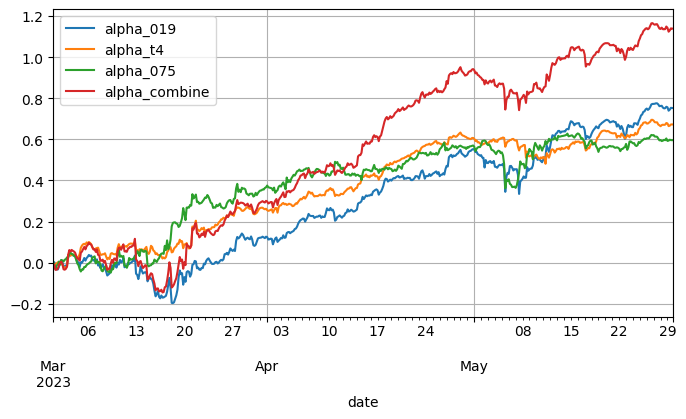

In [15]:
date_list = alpha_df.index.unique()
facret_df = pd.DataFrame(index = date_list)

for ii, dt in zip(calendar,date_list): 
    for alp in alpha_field: 
        facret_df.at[dt, alp] = facret[ii][alp]
        
facret_df = facret_df.sort_values(by=['date'])
# for column in alpha_field:
#     plt.plot(facret_df[column].cumsum(), label=column)
#     #plt.plot((1+facret_df[column]).cumprod(), label=column)
    
# plt.grid(True)
# plt.legend(loc='upper left')
# plt.xlabel('Date')
# plt.ylabel('Cumulative Factor Returns')
# plt.show()
facret_df[alpha_field].cumsum().plot(grid=True)

### PCA model
We use PCA algorithm to estimate risk

In [16]:
from sklearn.decomposition import PCA

class RiskModel(object):
    def __init__(self, returns, num_factor_exposures, ann_factor=20):
        
        self.num_factor_exposures = num_factor_exposures
        self.pca = PCA(n_components=num_factor_exposures, svd_solver='full')
        self.pca.fit(returns)
        
        self.factor_betas_ = self.factor_betas(self.pca, returns.columns.values, np.arange(num_factor_exposures))
        self.factor_returns_ = self.factor_returns(self.pca, returns, returns.index, np.arange(num_factor_exposures))
        self.estimate_returns = self.estimate_returns(self.factor_returns_, self.factor_betas_, returns)
        self.factor_cov_matrix_ = self.factor_cov_matrix(self.factor_returns_, ann_factor)
        
        self.idiosyncratic_var_matrix_ = self.idiosyncratic_var_matrix(returns, self.estimate_returns, ann_factor)
        self.idiosyncratic_var_vector = pd.DataFrame(data=np.diag(self.idiosyncratic_var_matrix_),
                                                     index=returns.columns)
    
    # got new exposure expressed by pca model
    def factor_betas(self, pca, factor_beta_indices, factor_beta_columns):
        return pd.DataFrame(pca.components_.T, factor_beta_indices, factor_beta_columns)
    
    # got new factor returns expressed by pca model
    def factor_returns(self, pca, returns, factor_return_indices, factor_return_columns):
        return pd.DataFrame(pca.transform(returns), factor_return_indices, factor_return_columns)
    
    # got new factor covariance matirx by pca expressed returns
    def factor_cov_matrix(self, factor_returns, ann_factor):
        return np.diag(factor_returns.var(axis=0, ddof=1) * ann_factor)
    
    def estimate_returns(self, factor_returns, factor_betas, returns):
        return pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
    
    # calculate idiosyncratic need to got factor_returns, factor_betas which calculate by pca model first
    def idiosyncratic_var_matrix(self, returns, estimate_returns, ann_factor):
        residuals = returns - estimate_returns
        return pd.DataFrame(np.diag(np.var(residuals))*ann_factor, returns.columns, returns.columns)
    
    def plot_principle_risk(self):
        # Make the bar plot
        plt.bar(np.arange(self.num_factor_exposures), self.pca.explained_variance_ratio_)

In [17]:
def rolling_df_by_day(df, start_time):
    pca_time_window = len(df.loc[df.index<start_time].index.unique())
    print(f'pca window_len is {pca_time_window}')
    #trade_date_list = df.loc[df['trade_date']>=start_time].trade_date.unique()
    all_date_list = df.index.unique()
    for start_i in range(len(all_date_list)):
        start_date = all_date_list[start_i]
        if start_i + pca_time_window >= len(all_date_list):
            break
        end_date = all_date_list[start_i + pca_time_window]
        yield end_date, df.loc[(df.index>=start_date) & (df.index<=end_date)]
        
def risk_by_PCA(returns_df):
#     for col in returns_df.columns:
#         returns_df[col] = np.where(returns_df[col]<0, returns_df[col], 0.)
    
    # Set the number of factor exposures (principal components) for the PCA algorithm
    num_factor_exposures = 3
    # Create a RiskModel object
    rm = RiskModel(returns_df, num_factor_exposures)
    
    B = rm.factor_betas_
    F = rm.factor_cov_matrix_
    S = rm.idiosyncratic_var_matrix_
    fr = rm.factor_returns_
    #fr = rm.estimate_returns
    
    variance = np.dot(B, F).dot(B.T) + S
    return variance, B, fr, rm.idiosyncratic_var_vector, F

# test
dt, df = next(rolling_df_by_day(all_factors, start_time))
returns_df = df.pivot(index='trade_date', columns='ts_code', values='log-ret').fillna(0)
variance_i, B, risk_fr, residual_i, F = risk_by_PCA(returns_df)
print(f'return date {dt}')
variance_i.head()

pca window_len is 20
return date 2023-03-01 00:00:00


ts_code,ACHUSDT,ADAUSDT,APEUSDT,APTUSDT,ATOMUSDT,AVAXUSDT,BNBUSDT,BTCUSDT,CFXUSDT,DOGEUSDT,...,NEARUSDT,OPUSDT,SANDUSDT,SHIBUSDT,SOLUSDT,STXUSDT,TRXUSDT,UMAUSDT,WOOUSDT,XRPUSDT
ts_code,,,,,,,,,,,,,,,,,,,,,
ACHUSDT,0.025115,0.003884,0.005103,0.006060,0.001980,0.002882,0.001586,0.001950,0.025977,0.002091,...,0.003739,0.005542,0.004841,0.004272,0.003424,0.010412,-0.000165,0.001879,0.006464,0.000231
ADAUSDT,0.003884,0.002295,0.002567,0.003456,0.001606,0.001819,0.000910,0.001080,0.007111,0.001265,...,0.002710,0.003975,0.002653,0.001896,0.002359,0.000853,0.000621,0.002405,0.003240,0.000539
APEUSDT,0.005103,0.002567,0.004502,0.004958,0.002264,0.002577,0.001291,0.001562,0.009182,0.001760,...,0.003949,0.005486,0.003758,0.002643,0.003351,0.002575,0.000848,0.003422,0.004489,0.000751
APTUSDT,0.006060,0.003456,0.004958,0.008061,0.003138,0.003550,0.001773,0.002156,0.011535,0.002404,...,0.005518,0.007520,0.005146,0.003562,0.004633,0.003797,0.001206,0.004809,0.006072,0.001057
ATOMUSDT,0.001980,0.001606,0.002264,0.003138,0.001823,0.001668,0.000823,0.000980,0.004966,0.001143,...,0.002568,0.003665,0.002378,0.001615,0.002193,0.000428,0.000659,0.002377,0.002824,0.000544


In [18]:
h=np.array([1/35]*35) 
(np.dot(h, variance_i).dot(h.T))** 0.5

0.05657200861776961

In [19]:
variance_all = {}
residual_df = pd.DataFrame()

for dt, df in rolling_df_by_day(all_factors, start_time):
    ticker_list = all_factors.loc[dt].ts_code.unique()
    df = df.loc[df.ts_code.isin(ticker_list)]
    returns_df = df.pivot(index='trade_date', columns='ts_code', values='log-ret').fillna(0)
    variance_i, B, risk_factor, residual_i, F = risk_by_PCA(returns_df)
    variance_all[dt] = [variance_i, B, risk_factor.iloc[-1,:], residual_i.copy(), F]
    residual_i['trade_date'] = df.loc[df.index[-1],'trade_date'].unique()[-1]
    residual_df = residual_df.append(residual_i)

residual_df.reset_index(inplace=True)
residual_df.columns = ['ts_code', 'residual', 'trade_date']
residual_df['residual'] = np.where(residual_df['residual'].isnull(), residual_df['residual'].median(), residual_df['residual'])
all_factors = all_factors.loc[all_factors['trade_date']>=start_time]
all_factors = all_factors.merge(residual_df, on=['trade_date','ts_code'], how='left')
#all_factors.tail()
print(residual_df.shape, all_factors.shape)

pca window_len is 20
(18900, 3) (18900, 10)


### Combine Factors

<AxesSubplot:>

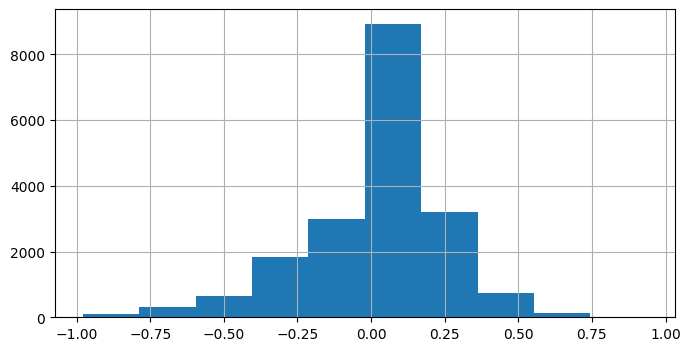

In [20]:
all_factors_new['alpha_combine'].hist()

In [22]:
#'alpha_028', 'alpha_ppo', 'alpha_wtr', 'alpha_AI', 
all_factors = all_factors_new.reset_index().copy(deep=True)
alpha_df = all_factors.drop(columns=['returns_2']).set_index(['date', 'ts_code']).sort_index(level=['date', 'ts_code'])
alpha_df['alpha_all'] = alpha_df['alpha_075']
#alpha_df['alpha_all'] = 0.5 * alpha_df['alpha_AI'] + 0.5*alpha_df['alpha_019']
print(max(alpha_df['alpha_all']), min(alpha_df['alpha_all']))

1.1009903385458226 -1.1401828324981123


In [23]:
# for dt in alpha_df.index.get_level_values(0).unique():
#     tmp = alpha_df.loc[dt]
#     print(tmp['trade_date'])

In [24]:
alpha_df.index.get_level_values(0).unique()

DatetimeIndex(['2023-03-01 00:00:00', '2023-03-01 04:00:00',
               '2023-03-01 08:00:00', '2023-03-01 12:00:00',
               '2023-03-01 16:00:00', '2023-03-01 20:00:00',
               '2023-03-02 00:00:00', '2023-03-02 04:00:00',
               '2023-03-02 08:00:00', '2023-03-02 12:00:00',
               ...
               '2023-05-28 08:00:00', '2023-05-28 12:00:00',
               '2023-05-28 16:00:00', '2023-05-28 20:00:00',
               '2023-05-29 00:00:00', '2023-05-29 04:00:00',
               '2023-05-29 08:00:00', '2023-05-29 12:00:00',
               '2023-05-29 16:00:00', '2023-05-29 20:00:00'],
              dtype='datetime64[ns]', name='date', length=540, freq=None)

### Backtest by Convex Optimization(Choice one option)

### Option One
- use `cvxpy` to optimized portfolio
- lambda expressed a transaction costs weights
- aversion expressed max risk to endure

In [25]:
calendar = alpha_df.index.get_level_values(0).unique()
ticker_num = len(alpha_df.index.get_level_values(1).unique())

# get parameter
positions = {}
alpha_df['h_privious'] = 0.
h0 = [0.] * ticker_num
aversion = 0.05
Lambda = 5e-4

In [26]:
#alpha_df['alpha_019'].hist()
#variance_all[calendar[100]][4]

In [27]:
from helper.project_helper import OptimalHoldings

#dt = '2022-04-10 00:00:00'
dt = calendar[100]
obj_df = alpha_df.loc[alpha_df.index.get_level_values(0)==dt]
alpha_vector = obj_df.loc[obj_df.index.get_level_values(0)[-1]][['alpha_all']]
optimal_weights = OptimalHoldings(aversion=aversion, weights_max=0.3, weights_min=-0.3, lambda_reg=.3).find(alpha_vector, variance_all[dt][1],
                            variance_all[dt][4],  variance_all[dt][3], obj_df['h_privious'], Lambda = Lambda)
optimal_weights.loc[optimal_weights[0]>=0.005]

,0
ts_code,
ACHUSDT,0.121824
APEUSDT,0.023714
CFXUSDT,0.080550
DYDXUSDT,0.063515
MAGICUSDT,0.256701
MASKUSDT,0.053697


In [28]:
calendar[1]

Timestamp('2023-03-01 04:00:00')

In [29]:
oh_obj = OptimalHoldings(aversion=aversion, weights_max=0.3, weights_min=-0.3, lambda_reg=.3)
for dt in tqdm(calendar, desc='optimized holding...'):
    # fill yesterday holding
    obj_df = alpha_df.loc[alpha_df.index.get_level_values(0)==dt]
    alpha_vector = obj_df.loc[obj_df.index.get_level_values(0)[-1]][['alpha_all']]
    # convex optimize
    optimal_weights = oh_obj.find(alpha_vector, variance_all[dt][1],
                            variance_all[dt][4],  variance_all[dt][3], obj_df['h_privious'],Lambda = Lambda)
    h_optimal = optimal_weights
    
    # update optimize holding
    #h_optimal[0] = np.where((h_optimal[0] - obj_df['h_privious']).abs() > 0.05, h_optimal, obj_df['h_privious'])
    obj_df['h_opt'] = h_optimal.values
    obj_df['h_privious'] = h0
    positions[dt]= obj_df
    h0 = h_optimal.values

optimized holding...: 100%|███████████████████| 540/540 [00:49<00:00, 10.93it/s]


### Option Two
- use `scipy.optimize.fmin_l_bfgs_b` to optimized portfolio
- lambda expressed a transaction costs weights
- aversion expressed a risk 1 posistion map to reduce how much risk

In [30]:
# the lambda expressed a transaction costs weights
def get_obj_func(h0, variance, alpha, Lambda=5e-4, aversion=0.5): 
    def obj_func(h):
        #f = 0.5 * aversion * np.dot(h, variance).dot(h.T) - aversion * np.matmul(h, alpha) + np.dot((h-h0)**2, Lambda)
        f =  - np.matmul(h, alpha) \
             + 0.5 * aversion * (np.dot(h, variance).dot(h.T)) \
             + np.dot((h-h0)**2, Lambda**2) \
             + 0.5 * alpha * np.linalg.norm(h) \

             
        return f
    return obj_func

def get_grad_func(h0, variance, alpha, Lambda=3e-6, aversion=1e-4):
    def grad_func(h):
        #f_hat =  aversion * np.dot(variance, h) - aversion * alpha + 2 * Lambda * (h-h0)
        f_hat =  - alpha  \
                + aversion * np.dot(variance, h) \
                + 2 * Lambda * (h-h0) \
                + 0.5 * 0.5 * alpha
        return f_hat
    return grad_func

# get parameter
bounds = [(-.25, .25)] * ticker_num

# for dt in calendar:
#     # fill yesterday holding
#     obj_df = alpha_df.loc[alpha_df.index.get_level_values(0)==dt]
#     # convex optimize
#     obj_func = get_obj_func(h0, variance_all[dt][0], obj_df['alpha_all'].values)
#     grad_func = get_grad_func(h0, variance_all[dt][0], obj_df['alpha_all'].values)
#     h_optimal, min_val, _ = fmin_l_bfgs_b(obj_func, h0, fprime=grad_func, bounds=bounds)
#     #h_optimal, min_val, _ = fmin_l_bfgs_b(obj_func, h0, fprime=grad_func)
#     # update optimize holding
#     obj_df['h_opt'] = h_optimal
#     obj_df['h_privious'] = h0
#     positions[dt]= obj_df
#     h0 = h_optimal

In [31]:
import copy
positions_bak = copy.deepcopy(positions)

In [ ]:
positions = copy.deepcopy(positions_bak)

0.19999999999925983 -0.1999999999991771
-0.025868025039782524 -0.09272552160689704


<AxesSubplot:xlabel='date'>

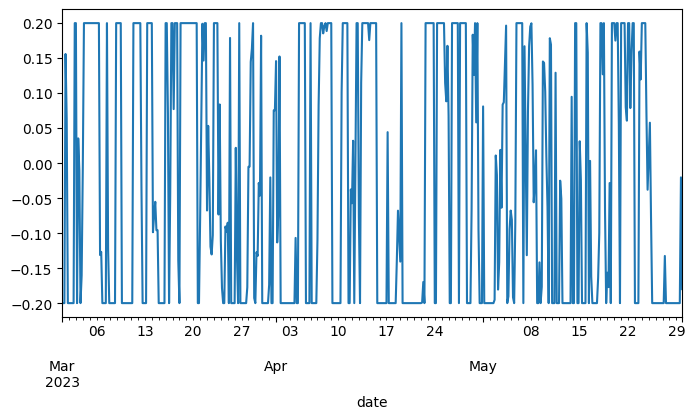

In [32]:
all_positions = []
for dt in list(positions.keys()):
    all_positions.append(positions[dt].h_opt.sum())
print(max(all_positions), min(all_positions))
print(np.mean(all_positions), np.median(all_positions))
#positions[20230315]['h_opt'].hist()
#calendar = all_factors['trade_date'].unique()
pd.Series(all_positions, index=calendar).plot()

### Money to optimal weights

In [33]:
holding_money = 1e5
for i in positions.keys():
    #positions[i]['h_opt'] = np.where(positions[i]['h_opt'].abs() < 0.1, 0, positions[i]['h_opt'])
    #positions[i]['h_privious'] = np.where(positions[i]['h_privious'].abs() < 0.1, 0, positions[i]['h_privious'])
    positions[i]['h_opt'] = positions[i]['h_opt'] * holding_money
    positions[i]['h_privious'] = positions[i]['h_privious'] * holding_money

In [34]:
h_optimal_list = [positions[dt]['h_opt'] for dt in positions.keys() ]
h_privious_list = [positions[dt]['h_privious'] for dt in positions.keys() ]

48981.43353317829 (11, 10)


close   log-ret    h_privious         h_opt
date                ts_code                                                  
2023-05-29 16:00:00 APEUSDT    0.444215  0.000917  9.743864e+03   6619.040955
                    APTUSDT    1.244266  0.001806 -2.266442e-07   8554.819223
                    CFXUSDT    2.205479 -0.010811  2.460899e-07  13384.412293
                    EGLDUSDT   0.257851  0.003796 -1.634131e-07  -3322.253625
                    FTMUSDT    0.198196 -0.003225 -6.981072e+03  19780.500780
                    GALAUSDT   0.124439  0.000975 -1.167820e+04  -4069.905018
                    LTCUSDT    0.837751  0.002731 -7.773196e-07  -8949.212797
                    MAGICUSDT  1.106295 -0.000476 -7.098070e+03 -29056.709308
                    MASKUSDT   1.019737  0.020819 -5.579740e+03  -4164.205378
                    NEARUSDT   0.180610  0.001825  7.037228e+03    642.660281
                    WOOUSDT    0.452709 -0.003527 -7.388874e-07  -1456.280335

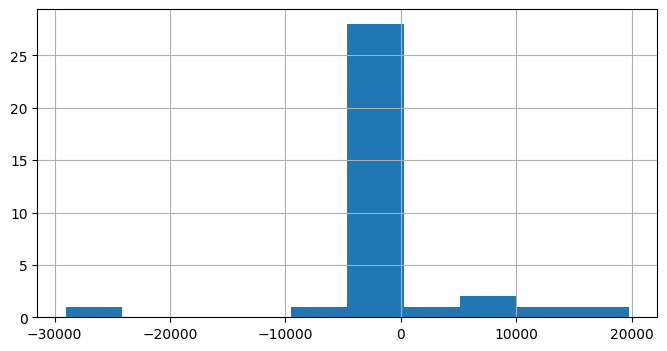

In [35]:
date_hold = list(positions.keys())[-2]
positions[date_hold]['h_opt'].hist()
tmp = positions[date_hold].loc[(positions[date_hold]['h_opt']>100) | (positions[date_hold]['h_opt']<-100)]
print(positions[date_hold].loc[positions[date_hold]['h_opt']>0]['h_opt'].sum(), tmp.shape)
tmp[['close','log-ret','h_privious', 'h_opt']]

### Calculate Exposure and Transaction Costs
We use pca to calculate risk, so we can view residual(alpha) as risk exposure.

<AxesSubplot:title={'center':'Risk Exposure'}, xlabel='date'>

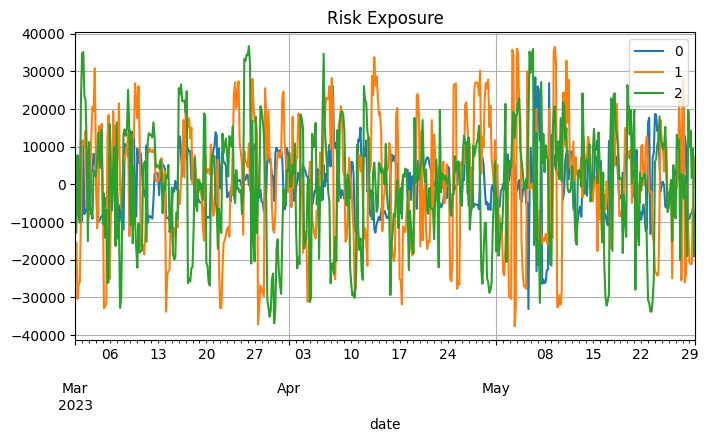

In [36]:
#plt.rcParams['figure.figsize'] = [7, 3]
risk_exposures_df = pd.DataFrame()
risk_exposures = {}
for ii, dt in enumerate(positions.keys()):
    # estimate_returns = pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
    B = variance_all[dt][1]
    h_opt_i = h_optimal_list[ii]
    risk_exposure = np.matmul(h_opt_i.T, B)
    risk_exposures[dt] = risk_exposure
    risk_exposures_df = risk_exposures_df.append(risk_exposure, ignore_index=True)

#np.sum(risk_exposures)
risk_exposures_df.set_index(pd.to_datetime(calendar, format='%Y-%m-%d %H:%M:%S'), inplace=True)
risk_exposures_df.plot(grid=True, title='Risk Exposure')
#risk_exposures_df.head()

In [37]:
all_factors = all_factors_new
universe.ts_code.unique()

array(['ACHUSDT', 'ADAUSDT', 'APEUSDT', 'APTUSDT', 'ATOMUSDT', 'AVAXUSDT',
       'BNBUSDT', 'BTCUSDT', 'CFXUSDT', 'DOGEUSDT', 'DOTUSDT', 'DYDXUSDT',
       'EGLDUSDT', 'ETHUSDT', 'FILUSDT', 'FTMUSDT', 'GALAUSDT', 'GMTUSDT',
       'LINKUSDT', 'LTCUSDT', 'LUNCUSDT', 'MAGICUSDT', 'MANAUSDT',
       'MASKUSDT', 'MATICUSDT', 'NEARUSDT', 'OPUSDT', 'SANDUSDT',
       'SHIBUSDT', 'SOLUSDT', 'STXUSDT', 'TRXUSDT', 'UMAUSDT', 'WOOUSDT',
       'XRPUSDT'], dtype=object)

### Alpha Exposure

<AxesSubplot:>

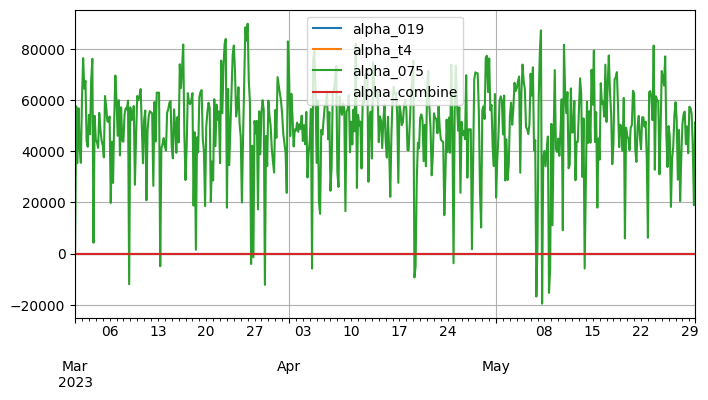

In [38]:
import patsy
import pandas

def colnames(B):
    if type(B) == patsy.design_info.DesignMatrix: 
        return B.design_info.column_names
    if type(B) == pandas.core.frame.DataFrame: 
        return B.columns.tolist()
    return None

def get_B_alpha(universe):
    alpha_factors = factors_from_names(list(universe),'alpha_')
    formula = get_formula(alpha_factors, "returns_2")
    outcome, B_alpha = patsy.dmatrices(formula, universe)
    return B_alpha

alpha_df_ = alpha_df.merge(all_factors[['trade_date','ts_code','returns_2']], on=['trade_date','ts_code'], how='left')
calendar = alpha_df.trade_date.unique()
alpha_exposure_df = pd.DataFrame()
alpha_exposures = {}
for ii, dt in enumerate(calendar):
    alpha_df_i = alpha_df_.loc[alpha_df_.trade_date==dt][['trade_date','ts_code',
                            'alpha_019', 'alpha_t4', 'alpha_075', 'alpha_combine', 'returns_2']]
    h_opt_i = h_privious_list[ii]
    B_alpha = get_B_alpha(alpha_df_i)
    
    B_alpha = B_alpha * [[0., 0., 1., 0.]] 
    #alpha_exposure = pd.Series(np.matmul(B_alpha.transpose(), h_opt_i), index=colnames(B_alpha))
    alpha_exposure = pd.Series(np.matmul(B_alpha.transpose(), h_opt_i), index=[
                    'alpha_019', 'alpha_t4', 'alpha_075', 'alpha_combine'])
    alpha_exposures[dt] = alpha_exposure
    alpha_exposure_df = pd.concat([alpha_exposure_df,alpha_exposure], axis=1)

alpha_exposure_df = alpha_exposure_df.T.reset_index(drop=True)
alpha_exposure_df.set_index(pd.to_datetime(calendar, format='%Y-%m-%d %H:%M:%S'), inplace=True)
alpha_exposure_df.plot(grid=True)

In [39]:
len(h_optimal_list)

540

16667.307128650667 59999.999997371415


<AxesSubplot:>

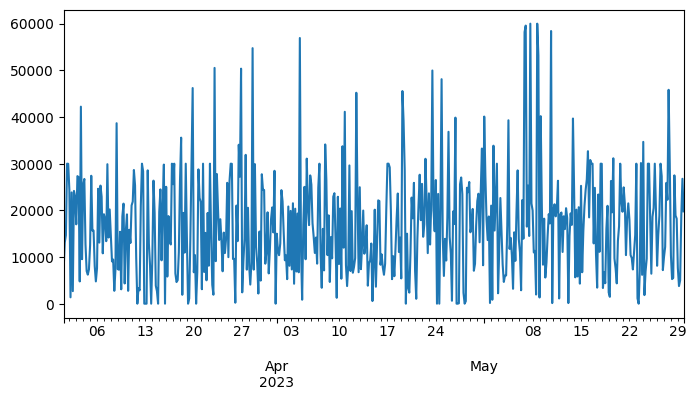

In [40]:
retre_list = []
for i in range(1,len(h_optimal_list)):
    tmp_change = h_optimal_list[i] - h_privious_list[i]
    retre_list.append(tmp_change.abs().max())
print(np.sum(retre_list)/len(h_optimal_list), np.max(retre_list))
pd.Series(retre_list, index=pd.to_datetime(calendar[1:], format='%Y%m%d %H:%M:%S')).plot()

17342.903237406492


<AxesSubplot:>

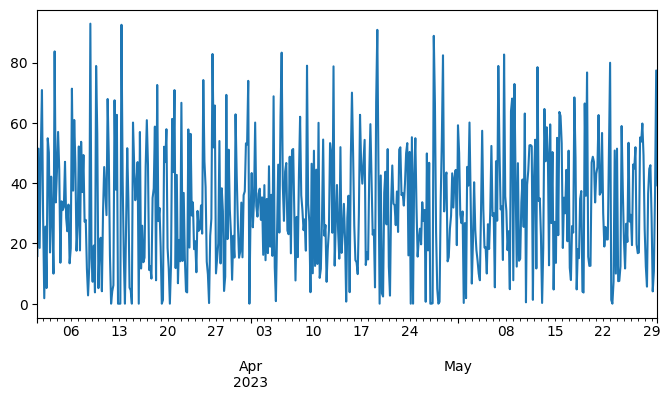

In [43]:
transaction_costs = []
Lambda = 5e-4
for i in range(1,len(h_optimal_list)):
    tmp_change = h_optimal_list[i] - h_privious_list[i]
    costs = sum(np.dot(tmp_change**2, Lambda**2)**0.5)
    #costs = sum(abs(tmp_change) * Lambda)
    transaction_costs.append(costs)
print(np.sum(transaction_costs))
pd.Series(transaction_costs, index=pd.to_datetime(calendar[1:], format='%Y%m%d %H:%M:%S')).plot()

In [ ]:
#h_optimal_list[i] - h_privious_list[i]
sum(abs(tmp_change) * Lambda)/5e-4

### Profit-and-Loss (PnL)

In [ ]:
all_factors

2023-05-29 12:00:00


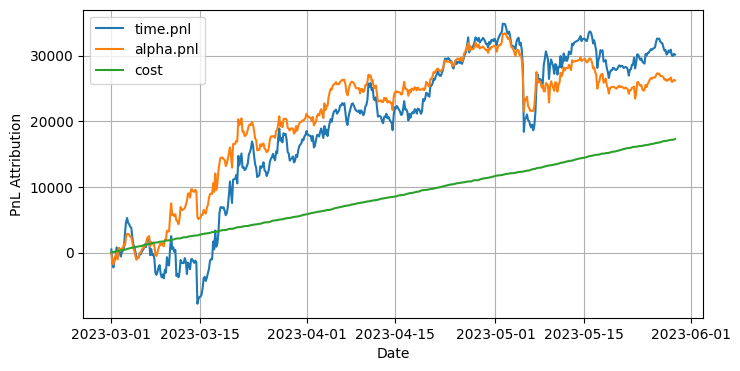

In [45]:
all_factors['date'] = all_factors['trade_date']
all_factors = all_factors.set_index(['date']).sort_values(by=['date'])

## assumes v, w are pandas Series 
def partial_dot_product(v, w):
    common = v.index.intersection(w.index)
    return np.sum(v[common] * w[common])

def build_pnl_attribution(): 

    df = pd.DataFrame(index = all_factors['trade_date'].unique()).iloc[:-2,:]
    calendar = all_factors.trade_date.unique()
    counter = range(len(calendar))
    for ii, dt, time_i in zip(counter,calendar, df.index):
        # holding frame
        p = positions[time_i]
        # alpha f
        fr = facret[time_i].loc[['alpha_019', 'alpha_t4', 'alpha_075', 'alpha_combine']]
        # risk f
        rr = variance_all[time_i][2]
        row_universe = all_factors.loc[all_factors.trade_date==dt]
        mf = p[['h_privious', 'h_opt']].merge(row_universe[['ts_code', 'returns_2']], how = 'left', on = "ts_code")  
        #mf['returns_2'] = wins(mf['returns_2'], -0.05, 0.05)
        df.at[time_i,"time.pnl"] = np.sum(mf['h_opt'] * mf['returns_2'])
        df.at[time_i,"alpha.pnl"] = partial_dot_product(fr, alpha_exposures[dt])
        #df.at[time_i,"risk.pnl"] = partial_dot_product(rr, risk_exposures[time_i])
        #df.at[time_i,"risk.pnl"] = np.sum(rr.values * risk_exposures[dt].values)/(-1)
        df.at[time_i,"cost"] = transaction_costs[ii]
        #df.at[time_i,"benchmark.pnl"] = positions[dt]['h_opt'].sum() * \
                            #benchmark_return.loc[benchmark_return.trade_date==dt]['log-ret'].values[0]
    
    print(time_i)
    return df

attr = build_pnl_attribution()
plt.grid(True)
for column in attr.columns:
    plt.plot(attr[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('PnL Attribution')
plt.show()

In [46]:
# 总收益
attr['time.pnl'].sum()

30158.39896262707

In [47]:
# 最小余额
attr['time.pnl'].cumsum().min()

-7787.721728840581

In [48]:
# 最大余额时间
attr['time.pnl'].cumsum().idxmax()

Timestamp('2023-05-02 04:00:00')

In [49]:
# 因子归因收益
attr['alpha.pnl'].sum()

26237.106481089562

In [50]:
# 因子夏普比率
(np.sqrt(252 * 12) * attr['alpha.pnl'].mean()- 0.00017*100000)/attr['alpha.pnl'].std()

3.4412102115835124

In [51]:
# 回测夏普比率
(np.sqrt(252 * 12)* attr['time.pnl'].mean() - 0.00017*100000)/attr['time.pnl'].std()

2.8765712939732637

In [52]:
# 最大回撤比例及时间
portfolio_values = (100000 + attr['time.pnl'])
retre = ((portfolio_values.cummax() - portfolio_values.cummin())/portfolio_values.cummax())
max_retre_val = retre.max()
max_retre_time = retre.idxmax()
print(max_retre_time, max_retre_val)

2023-05-05 12:00:00 0.13798740523126624


In [53]:
# 胜率
attr.loc[attr['time.pnl']>0].shape[0]/attr.shape[0]

0.5464684014869888

In [54]:
# 平均盈利比率
attr.loc[attr['time.pnl']>0]['time.pnl'].sum()/attr.shape[0]

377.3671955476608

In [57]:
# 每笔交易损耗
np.sum(transaction_costs)/attr.shape[0]

32.23587962343214

In [55]:
# 平均每笔收益
attr['time.pnl'].sum()/attr.shape[0]

56.05650364800571

In [58]:
attr['time.pnl'].cumsum().max()

34864.67066863183

In [59]:
attr.shape

(538, 3)

In [ ]:
open_cap = pd.Series()
close_cap = pd.Series()
for i in range(1,len(h_optimal_list)):
    tmp_change = h_optimal_list[i] - h_privious_list[i]
    tmp_change = tmp_change[abs(tmp_change)>1000]
    open_cap = open_cap.append(tmp_change[tmp_change>0])
    close_cap = close_cap.append(tmp_change[tmp_change<0])

In [ ]:
open_cap.sum() - close_cap.sum()

In [ ]:
close_cap.size + open_cap.size